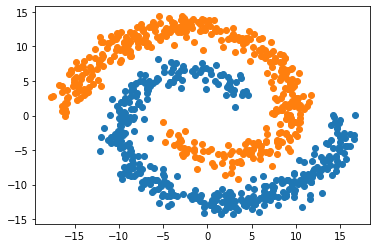

Number of points of each class:  (400, 2) (400, 2)


In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

N = 400
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

np.savetxt("result.csv", res, delimiter=",", header="x,y,label", comments="", fmt='%.5f')

plt.scatter(x_a[:,0],x_a[:,1])
plt.scatter(x_b[:,0],x_b[:,1])
plt.show()

print('Number of points of each class: ',x_a.shape, x_b.shape)

(600, 2) (200, 2)


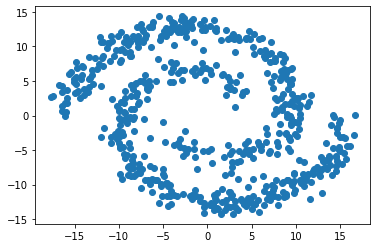

In [2]:
A = np.concatenate((x_a, x_b), axis = 0)
true_values = np.concatenate((np.ones((400,1)), np.zeros((400, 1))), axis = 0)

from sklearn.model_selection import train_test_split
A_train, A_test, y_train, y_test = train_test_split(A, true_values, test_size = 0.25, random_state = 0)

print(A_train.shape, A_test.shape)

plt.scatter(A_train[:,0],A_train[:,1])
# plt.scatter(x_b[:,0],x_b[:,1])
plt.show()


accuracy score using gaussian kernel:  0.98 



C:\Users\anura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


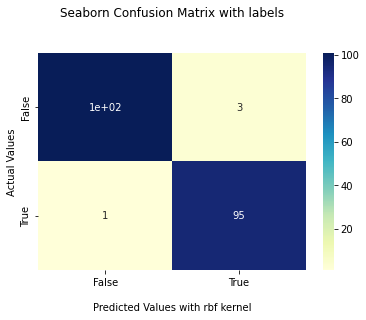

In [3]:
# First trying out with SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

X_train = pd.DataFrame(A_train, columns=['x', 'y'])
X_test = pd.DataFrame(A_test, columns=['x', 'y'])
Y_train = pd.DataFrame(y_train)
Y_test = pd.DataFrame(y_test)

svc = SVC(kernel='rbf')

svc.fit(X_train, Y_train)

Y_pred = svc.predict(X_test)


cf_mat = confusion_matrix(Y_test, Y_pred)


ax = sns.heatmap(cf_mat, annot = True, cmap='YlGnBu')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values with rbf kernel')
ax.set_ylabel('Actual Values')


## Ticket labels - List must be in alphabetical order

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
print('accuracy score using gaussian kernel: ',accuracy_score(Y_test, Y_pred), '\n')
##Displat the visualization of the confusion Matrix
plt.show()


[[226  70]
 [ 72 232]]


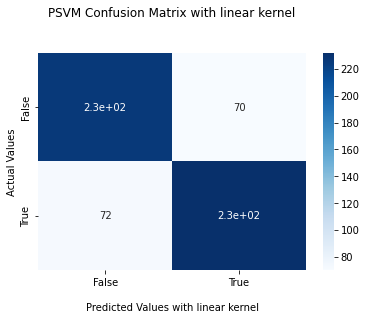

Accuracy score Linear PSVM classifier on training set

0.7633333333333333 0.7682119205298014
Now predicting on test dataset

test accuracy 0.73 0.71875 

margin between proximal planes is: 7.072029263536273


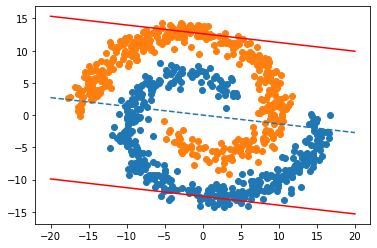

In [4]:
# PSVM implementation

m = 600  #training eg number
m1 = 200 #test eg number

# diagonal matrix
D = np.diagflat(y_train)
for i in range(m):
        if D[i][i] == 0:
            D[i][i] = -1

# ones vector        
o = np.ones((m, 1))

H = D.dot(np.concatenate((A_train, -o), axis = 1))
I = np.identity(m)
u = (I + H.dot(H.T))
u = np.linalg.inv(u).dot(o)

w = A_train.T.dot(D).dot(u)

gamma = (-o.T).dot(D).dot(u)
y = u

prediction1 = (A_train.dot(w)-gamma) > 0

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_train, prediction1)

print(cf_matrix)
ax = sns.heatmap(cf_matrix, annot = True, cmap='Blues')

ax.set_title('PSVM Confusion Matrix with linear kernel\n\n');
ax.set_xlabel('\nPredicted Values with linear kernel')
ax.set_ylabel('Actual Values')


## Ticket labels - List must be in alphabetical order

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

##Displat the visualization of the confusion Matrix
plt.show()
print('Accuracy score Linear PSVM classifier on training set\n')
print(accuracy_score(y_train, prediction1), precision_score(y_train, prediction1))

print('Now predicting on test dataset\n')
prediction2 = (A_test.dot(w)-gamma) > 0

print("test accuracy", accuracy_score(y_test, prediction2), precision_score(y_test, prediction2), '\n')


x0 = np.linspace(-20, 20, 400)

margin = 2/(np.sqrt(gamma*gamma + np.linalg.norm(w)))
print('margin between proximal planes is:', float(margin))
a = w[0]
b = w[1]
val = (gamma-a*x0)/b
val1 = (1+gamma-a*x0)/b
val2 = (-1+gamma-a*x0)/b
plt.scatter(x_a[:,0],x_a[:,1])
plt.scatter(x_b[:,0],x_b[:,1])

plt.plot(x0, (val.T), '--')
plt.plot(x0, (val1.T), 'r')
plt.plot(x0, (val2.T), 'r')

In [5]:
K = np.arange(m*m).reshape((m, m)).astype(float)
A_trainT = A_train.T
#using gaussian kernel K = K(A, A')
for i in range(m):
    for j in range(m):
        diff = np.square(np.linalg.norm(A_train[i,:]-A_trainT[:,j]))/2
        similarity = np.exp(diff/100)
        K[i][j] = similarity

In [6]:
# calculating G, gamma matrices
G = D.dot(np.concatenate((K, -o), axis=1))
# taking v (nu) as 1
v1 = (I+G.dot(G.T)) #v1 is lagrange multiplier
v1 = np.linalg.inv(v1).dot(o)
u1 = D.dot(K.T).dot(D).dot(v1)
gamma1 = (-o.T).dot(D).dot(v1)
error1 = v1

In [7]:
# predict using our classifier equation
output1 = (K.dot(D).dot(u1)-gamma1) > 0
print('Accuracy score and Precision score for Nonlinear PSVM with gaussian kernel')
accuracy_score(y_train, output1), precision_score(y_train, output1)

Accuracy score and Precision score for Nonlinear PSVM with gaussian kernel


(0.9533333333333334, 0.9539473684210527)

[[282  14]
 [ 14 290]]


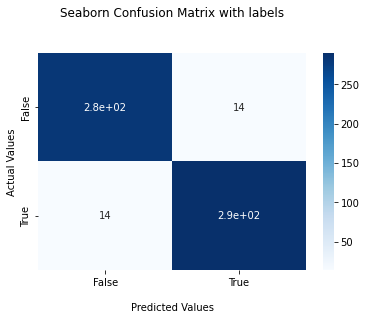

In [8]:
#Generate the confusion matrix
cf_matrix1 = confusion_matrix(y_train, output1)

print(cf_matrix1)
ax = sns.heatmap(cf_matrix1, annot = True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')


## Ticket labels - List must be in alphabetical order

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

##Displat the visualization of the confusion Matrix
plt.show()

# group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ["{0:0.0f}".format(value) for value in
#                 cf_matrix1.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix1.flatten()/np.sum(cf_matrix1)]
# labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#           zip(group_names,group_counts,group_percentages)]
# labels = np.asarray(labels).reshape(2,2)
# sns.heatmap(cf_matrix1, annot=labels, fmt='', cmap='Blues')

In [9]:
# pulsar_stars dataset from kaggle
import pandas as pd
data = 'C:/Users/anura/Documents/Python Learning/pulsar_data_train.csv'
df = pd.read_csv(data)
df.shape


(12528, 9)

In [10]:
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [11]:
# check distribution of target_class column

df['target_class'].value_counts()

0.0    11375
1.0     1153
Name: target_class, dtype: int64

In [12]:
# view the percentage distribution of target_class column

df['target_class'].value_counts()/float(len(df))

0.0    0.907966
1.0    0.092034
Name: target_class, dtype: float64

In [13]:
# rename column names

df.columns = ['IP Mean', 'IP Sd', 'IP Kurtosis', 'IP Skewness', 
              'DM-SNR Mean', 'DM-SNR Sd', 'DM-SNR Kurtosis', 'DM-SNR Skewness', 'target_class']

In [14]:
df.head()

,IP Mean,IP Sd,IP Kurtosis,IP Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   IP Mean          12528 non-null  float64
 1   IP Sd            12528 non-null  float64
 2   IP Kurtosis      10793 non-null  float64
 3   IP Skewness      12528 non-null  float64
 4   DM-SNR Mean      12528 non-null  float64
 5   DM-SNR Sd        11350 non-null  float64
 6   DM-SNR Kurtosis  12528 non-null  float64
 7   DM-SNR Skewness  11903 non-null  float64
 8   target_class     12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


In [16]:
df.isnull().sum()

IP Mean               0
IP Sd                 0
IP Kurtosis        1735
IP Skewness           0
DM-SNR Mean           0
DM-SNR Sd          1178
DM-SNR Kurtosis       0
DM-SNR Skewness     625
target_class          0
dtype: int64

In [17]:
df = df.dropna(axis = 0, how = 'any')
df.isnull().sum()

df.shape

(9273, 9)

# Summary of numerical variables
- There are 9 numerical variables in the dataset.
- 8 are continuous variables and 1 is discrete variable.
- The discrete variable is target_class variable. It is also the target variable.
- There are no missing values in the dataset.

In [18]:
round(df.describe(), 2)

,IP Mean,IP Sd,IP Kurtosis,IP Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness,target_class
count,9273.00,9273.00,9273.00,9273.00,9273.00,9273.00,9273.00,9273.00,9273.00
mean,111.13,46.51,0.48,1.79,12.74,26.33,8.33,105.78,0.09
std,25.69,6.78,1.07,6.29,29.77,19.54,4.55,108.17,0.29
min,6.19,24.77,-1.74,-1.79,0.21,7.37,-2.64,-1.98,0.00
25%,100.98,42.40,0.02,-0.19,1.91,14.38,5.79,34.92,0.00
50%,115.23,46.90,0.22,0.20,2.80,18.44,8.43,83.15,0.00
75%,127.33,51.00,0.47,0.93,5.46,28.39,10.72,139.77,0.00
max,189.73,91.81,8.07,68.10,211.95,110.64,34.54,1191.00,1.00


Text(0, 0.5, 'DM-SNR Skewness')

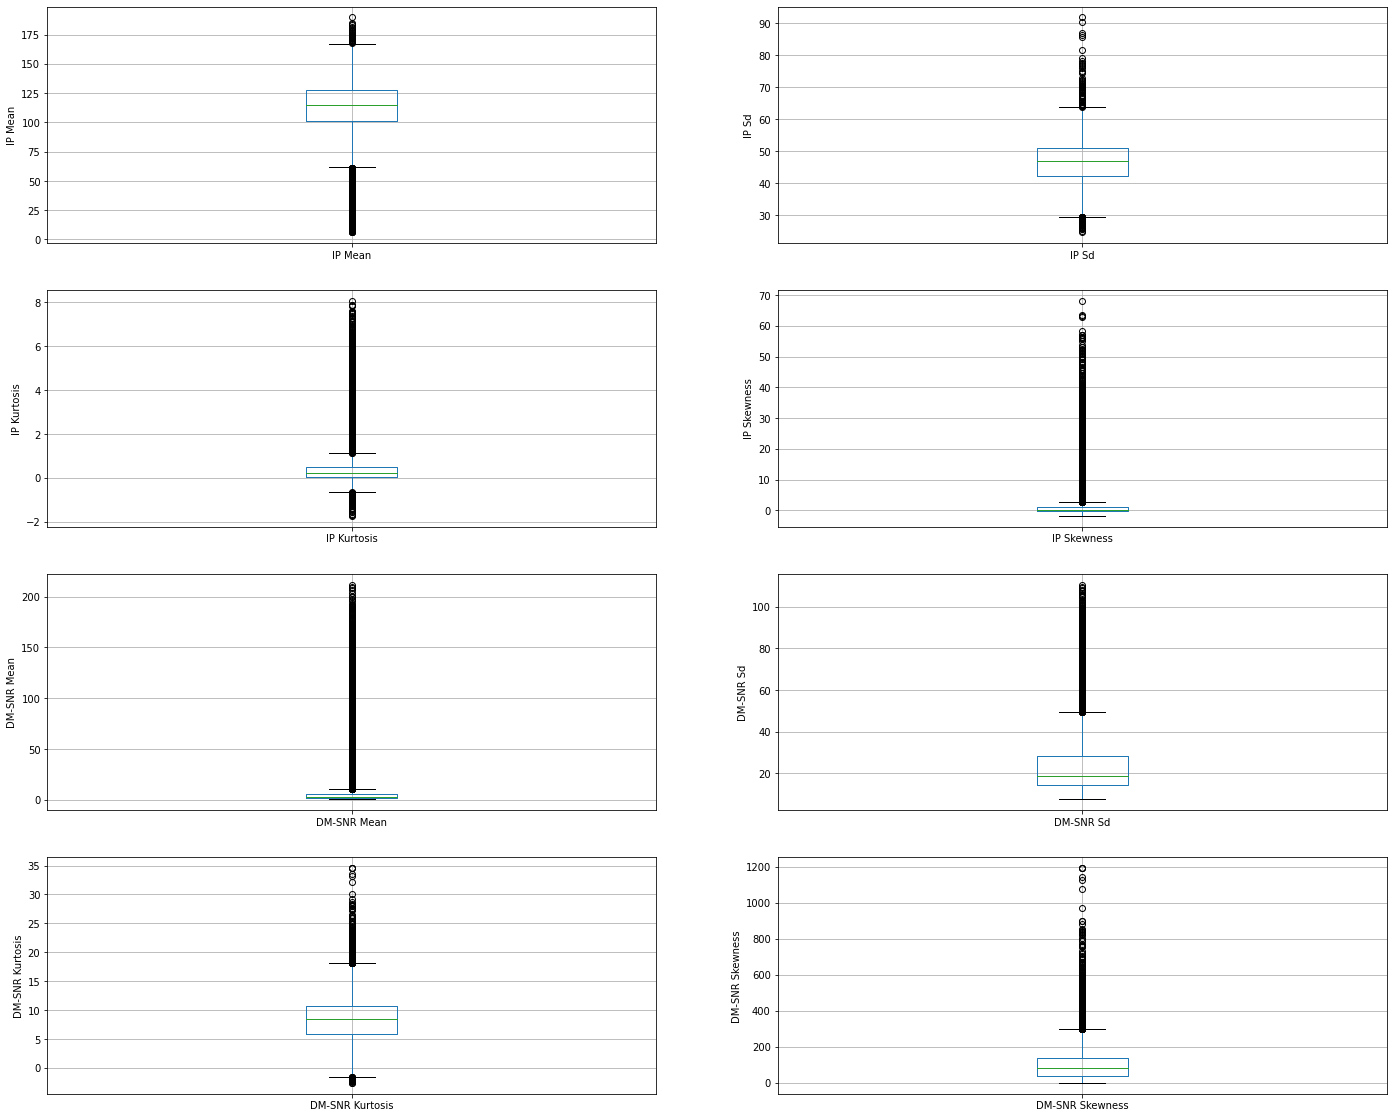

In [19]:
# draw boxplots to visualize outliers

plt.figure(figsize=(24,20))


plt.subplot(4, 2, 1)
fig = df.boxplot(column='IP Mean')
fig.set_title('')
fig.set_ylabel('IP Mean')


plt.subplot(4, 2, 2)
fig = df.boxplot(column='IP Sd')
fig.set_title('')
fig.set_ylabel('IP Sd')


plt.subplot(4, 2, 3)
fig = df.boxplot(column='IP Kurtosis')
fig.set_title('')
fig.set_ylabel('IP Kurtosis')


plt.subplot(4, 2, 4)
fig = df.boxplot(column='IP Skewness')
fig.set_title('')
fig.set_ylabel('IP Skewness')


plt.subplot(4, 2, 5)
fig = df.boxplot(column='DM-SNR Mean')
fig.set_title('')
fig.set_ylabel('DM-SNR Mean')


plt.subplot(4, 2, 6)
fig = df.boxplot(column='DM-SNR Sd')
fig.set_title('')
fig.set_ylabel('DM-SNR Sd')


plt.subplot(4, 2, 7)
fig = df.boxplot(column='DM-SNR Kurtosis')
fig.set_title('')
fig.set_ylabel('DM-SNR Kurtosis')


plt.subplot(4, 2, 8)
fig = df.boxplot(column='DM-SNR Skewness')
fig.set_title('')
fig.set_ylabel('DM-SNR Skewness')

Text(0, 0.5, 'Number of pulsar stars')

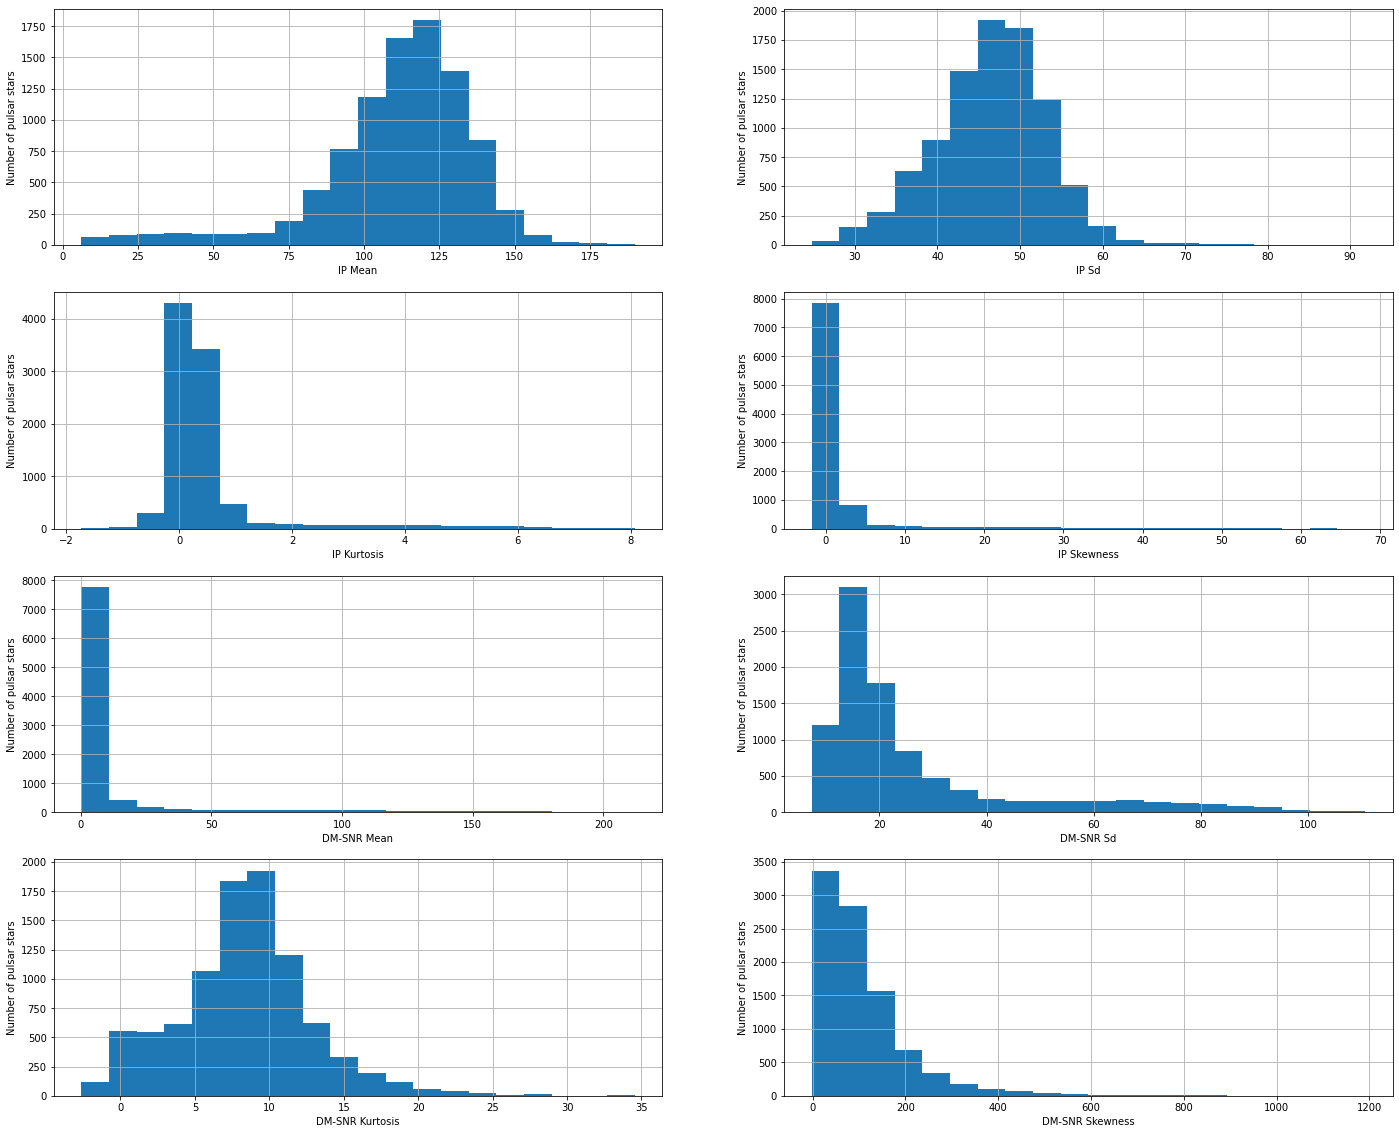

In [20]:

# plot histogram to check distribution


plt.figure(figsize=(24,20))


plt.subplot(4, 2, 1)
fig = df['IP Mean'].hist(bins=20)
fig.set_xlabel('IP Mean')
fig.set_ylabel('Number of pulsar stars')


plt.subplot(4, 2, 2)
fig = df['IP Sd'].hist(bins=20)
fig.set_xlabel('IP Sd')
fig.set_ylabel('Number of pulsar stars')


plt.subplot(4, 2, 3)
fig = df['IP Kurtosis'].hist(bins=20)
fig.set_xlabel('IP Kurtosis')
fig.set_ylabel('Number of pulsar stars')



plt.subplot(4, 2, 4)
fig = df['IP Skewness'].hist(bins=20)
fig.set_xlabel('IP Skewness')
fig.set_ylabel('Number of pulsar stars')



plt.subplot(4, 2, 5)
fig = df['DM-SNR Mean'].hist(bins=20)
fig.set_xlabel('DM-SNR Mean')
fig.set_ylabel('Number of pulsar stars')



plt.subplot(4, 2, 6)
fig = df['DM-SNR Sd'].hist(bins=20)
fig.set_xlabel('DM-SNR Sd')
fig.set_ylabel('Number of pulsar stars')



plt.subplot(4, 2, 7)
fig = df['DM-SNR Kurtosis'].hist(bins=20)
fig.set_xlabel('DM-SNR Kurtosis')
fig.set_ylabel('Number of pulsar stars')


plt.subplot(4, 2, 8)
fig = df['DM-SNR Skewness'].hist(bins=20)
fig.set_xlabel('DM-SNR Skewness')
fig.set_ylabel('Number of pulsar stars')

In [21]:
X = df.drop(['target_class'], axis=1)
y = df['target_class']

In [22]:
# split X and y into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [23]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

((7418, 8), (1855, 8))

In [24]:
cols = X_train.columns

print(cols)

Index(['IP Mean', 'IP Sd', 'IP Kurtosis', 'IP Skewness', 'DM-SNR Mean',
       'DM-SNR Sd', 'DM-SNR Kurtosis', 'DM-SNR Skewness'],
      dtype='object')


In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [27]:
X_test = pd.DataFrame(X_test, columns=[cols])

C:\Users\anura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\anura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


SVM Model accuracy score with default hyperparameters: 0.9805


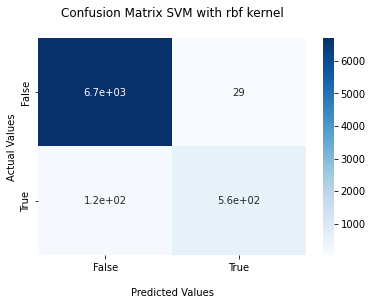

ROC AUC : 0.9124


In [28]:
# import SVC classifier
from sklearn.svm import SVC

#import metrics to compute accuracy
from sklearn.metrics import accuracy_score

#creating instant of classifier with default hyperparameters
svc = SVC(kernel='rbf')

#fit classifier to training set
svc.fit(X_train, y_train)

# make predictions on test set
y_pred=svc.predict(X_train)

# compute and print accuracy score
print('SVM Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_train, y_pred)))
cf_matrix = confusion_matrix(y_train, y_pred)

ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues')

ax.set_title('Confusion Matrix SVM with rbf kernel\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')


## Ticket labels - List must be in alphabetical order

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

##Displat the visualization of the confusion Matrix
plt.show()

# compute ROC AUC

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_train, y_pred)

print('ROC AUC : {:.4f}'.format(ROC_AUC))


In [29]:
X_train.describe()

,IP Mean,IP Sd,IP Kurtosis,IP Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness
count,7.418000e+03,7.418000e+03,7.418000e+03,7.418000e+03,7.418000e+03,7.418000e+03,7.418000e+03,7.418000e+03
mean,1.503845e-16,2.686806e-16,2.777803e-17,1.101542e-17,-4.214597e-17,-2.107298e-17,8.812339e-17,3.352520e-18
std,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00
min,-4.062595e+00,-3.195114e+00,-2.039801e+00,-5.630418e-01,-4.201420e-01,-9.704665e-01,-2.413736e+00,-9.966851e-01
25%,-3.886562e-01,-6.095197e-01,-4.225747e-01,-3.146418e-01,-3.626540e-01,-6.104157e-01,-5.597244e-01,-6.548497e-01
50%,1.634366e-01,6.559767e-02,-2.410595e-01,-2.543538e-01,-3.327143e-01,-4.046059e-01,2.075082e-02,-2.092757e-01
75%,6.275847e-01,6.658203e-01,-1.245402e-02,-1.410595e-01,-2.422847e-01,1.101465e-01,5.199843e-01,3.063228e-01
max,2.870438e+00,5.964328e+00,6.785511e+00,9.540137e+00,6.768125e+00,4.336626e+00,5.744530e+00,9.966367e+00


In [30]:
A_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [31]:
print(A_train.shape)

(7418, 8)


In [32]:
D = np.diagflat(y_train)
m = A_train.shape[0]
n = A_train.shape[1]

for i in range(m):
    if D[i][i] == 0:
        D[i][i] = -1

In [33]:
I = np.identity(m)
nu = 1

unique, counts = np.unique(D, return_counts=True)
dict(zip(unique, counts))


{-1.0: 6739, 0.0: 55019306, 1.0: 679}

In [34]:
# define H matrix

print(m, A_train.shape)
o = np.ones((m, 1))
H = D.dot(np.concatenate([A_train, -o], axis = 1))

#define nu
nu = 1

#calculate u
u = np.linalg.inv(I+H.dot(H.T)).dot(o)

7418 (7418, 8)


In [35]:
w = A_train.T.dot(D).dot(u)
gamma = (-o.T).dot(D).dot(u)
error = u/nu

In [36]:
pred = (A_train.dot(w)-gamma) > 0


Non Linear PSVM Model accuracy score: 0.9729


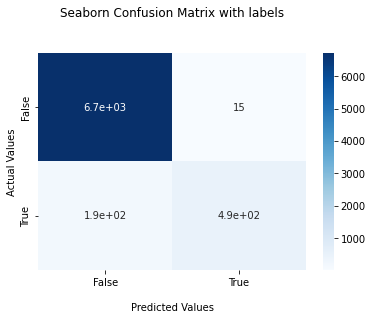

In [37]:
#Generate the confusion matrix
cf_matrix2 = confusion_matrix(y_train, pred)

ax = sns.heatmap(cf_matrix2, annot = True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

print('\nNon Linear PSVM Model accuracy score: {0:0.4f}'. format(accuracy_score(y_train, pred)))
## Ticket labels - List must be in alphabetical order

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

##Displat the visualization of the confusion Matrix
plt.show()

# Classification Report
### Classification report is another way to evaluate the classification model performance. It displays the precision, recall, f1 and support scores for the model.

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_train, pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      6739
         1.0       0.97      0.73      0.83       679

    accuracy                           0.97      7418
   macro avg       0.97      0.86      0.91      7418
weighted avg       0.97      0.97      0.97      7418



In [39]:
# compute ROC AUC

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_train, pred)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.8619


In [40]:
data = 'C:/Users/anura/Documents/Python Learning/Social_Network_Ads.csv'


In [41]:
data = 'C:/Users/anura/Documents/Python Learning/Social_Network_Ads.csv'

df1 = pd.read_csv(data)

In [42]:
df1.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [43]:
X = df1.iloc[:, [2, 3]].values
y = df1.iloc[:, [4]].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [45]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [47]:
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train.ravel())

SVC(random_state=0)

In [48]:
y_pred = classifier.predict(X_train) 


Linear SVM Model accuracy score: 0.7722



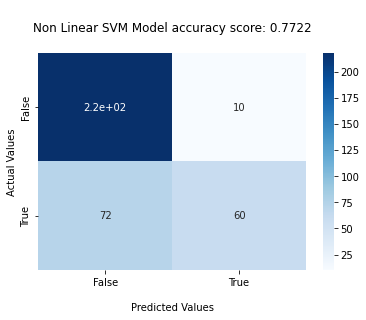

In [49]:
cf_matrix = confusion_matrix(y_train, y_pred)

ax = sns.heatmap(cf_matrix, annot = True, cmap='Blues')

ax.set_title('\nNon Linear SVM Model accuracy score: {0:0.4f}\n'. format(accuracy_score(y_train, y_pred)));
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

print('\nLinear SVM Model accuracy score: {0:0.4f}\n'. format(accuracy_score(y_train, y_pred)))
## Ticket labels - List must be in alphabetical order

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

##Displat the visualization of the confusion Matrix
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM Classification')
plt.xlabel('Age')
plt.ylabel('EstimatedSalary')
plt.legend()
plt.show()

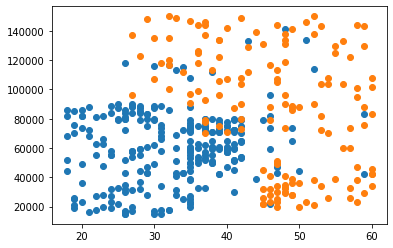

In [50]:
m = y.shape[0]
df1.head()
plt.scatter(df1['Age'][df1.Purchased == 0], df1['EstimatedSalary'][df1.Purchased == 0])
plt.scatter(df1['Age'][df1.Purchased == 1], df1['EstimatedSalary'][df1.Purchased == 1])

In [51]:
D = np.diagflat(y_train)
m = X_train.shape[0]
n = X_train.shape[1]

for i in range(m):
    if D[i][i] == 0:
        D[i][i] = -1

In [52]:
I = np.identity(m)
nu = 1

# define H matrix
o = np.ones((m, 1))
H = D.dot(np.concatenate([X_train, -o], axis = 1))

#calculate u
u = np.linalg.inv(I+H.dot(H.T)).dot(o)

[[5.00390566e-02]
 [7.35477079e-06]]


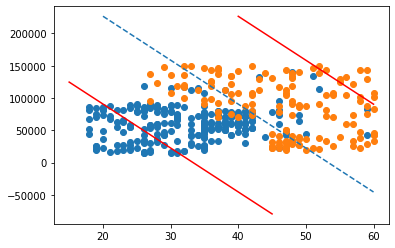

In [86]:
w = X_train.T.dot(D).dot(u)
gamma = (-o.T).dot(D).dot(u)
error = u/nu

print(w)
x0 = np.linspace(20, 60, 400)
x1 = np.linspace(15, 45, 400)
x2 = np.linspace(40, 60, 400)
a = w[0]
b = w[1]
val = (gamma-a*x0)/b
val1 = (1+gamma-a*x2)/b
val2 = (-1+gamma-a*x1)/b
plt.scatter(df1['Age'][df1.Purchased == 0], df1['EstimatedSalary'][df1.Purchased == 0])
plt.scatter(df1['Age'][df1.Purchased == 1], df1['EstimatedSalary'][df1.Purchased == 1])
# plt.scatter(X_train[:, 0], X_train[:, 1])
plt.plot(x0, (val.T), '--')
plt.plot(x2, (val1.T), 'r')
plt.plot(x1, (val2.T), 'r')

In [59]:
pred = (X_train.dot(w)-gamma) > 0

In [60]:
accuracy_score(y_train, pred)

0.8333333333333334


Linear PSVM Model accuracy score: 0.8333


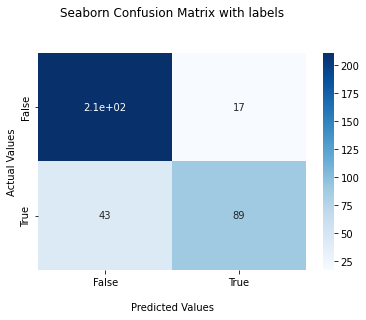

In [78]:
cf_matrix2 = confusion_matrix(y_train, pred)

ax = sns.heatmap(cf_matrix2, annot = True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

print('\nLinear PSVM Model accuracy score: {0:0.4f}'. format(accuracy_score(y_train, pred)))
## Ticket labels - List must be in alphabetical order

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

##Displat the visualization of the confusion Matrix
plt.show()

In [76]:
K = np.arange(m*m).reshape((m, m)).astype(float)
X_trainT = X_train.T
#using gaussian kernel K = K(A, A')
for i in range(m):
    for j in range(m):
        diff = np.square(np.linalg.norm(X_train[i,:]-X_trainT[:,j]))/2
#         print(diff/100000000)
        similarity = np.exp(diff/100000000)
        K[i][j] = similarity

In [77]:
# calculating G, gamma matrices
G = D.dot(np.concatenate((K, -o), axis=1))
# taking v (nu) as 1
v1 = (I+G.dot(G.T)) #v1 is lagrange multiplier
v1 = np.linalg.inv(v1).dot(o)
u1 = D.dot(K.T).dot(D).dot(v1)
gamma1 = (-o.T).dot(D).dot(v1)
error1 = v1

LinAlgError: Singular matrix

In [ ]:
# predict using our classifier equation
output1 = (K.dot(D).dot(u1)-gamma1) > 0
print('Accuracy score and Precision score for Nonlinear PSVM with gaussian kernel')
accuracy_score(y_train, output1), precision_score(y_train, output1)

In [ ]:
#Generate the confusion matrix
cf_matrix1 = confusion_matrix(y_train, output1)

ax = sns.heatmap(cf_matrix1, annot = True, cmap='Blues')

ax.set_title('\nNon Linear PSVM Model accuracy score: {0:0.4f}'. format(accuracy_score(y_train, output1)))
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')


## Ticket labels - List must be in alphabetical order

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

##Displat the visualization of the confusion Matrix
plt.show()

# Credit card dataset

In [111]:
data = 'C:/Users/anura/Documents/Python Learning/creditcard.csv'


In [148]:
df1 = pd.read_csv(data)
df1.shape

(284807, 31)

In [113]:
df1.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [115]:
df1.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


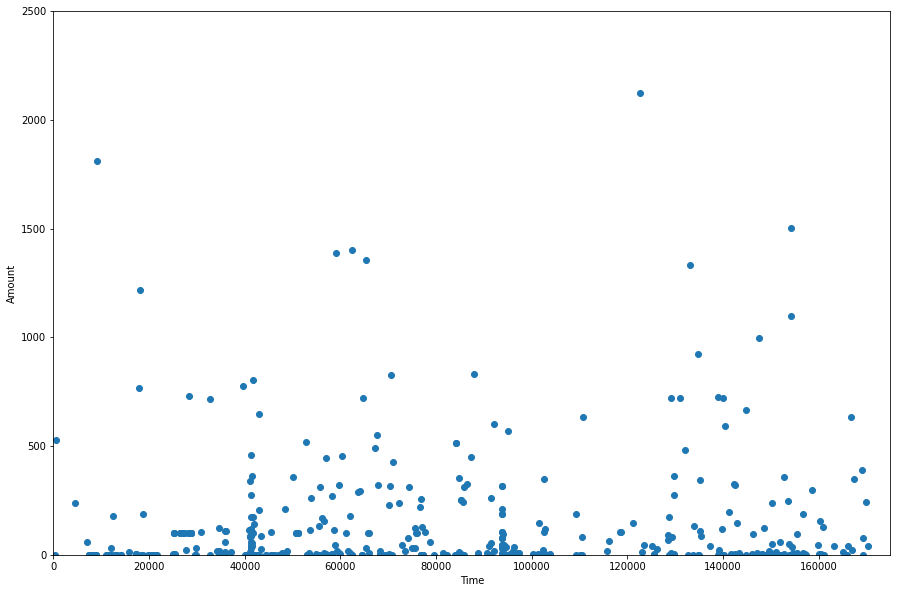

In [117]:
df_fraud = df1[df1['Class'] == 1] # Recovery of fraud data

plt.figure(figsize = (15, 10))
plt.scatter(df_fraud['Time'], df_fraud['Amount']) # Time vs Amount for fraud class
plt.xlabel('Time')
plt.ylabel('Amount')
plt.xlim([0, 175000])
plt.ylim([0, 2500])
plt.show()

In [122]:
number_fraud = len(df1[df1.Class == 1])
print("There are only",number_fraud, "number of frauds which is pretty low")

There are only 492 number of frauds which is pretty low


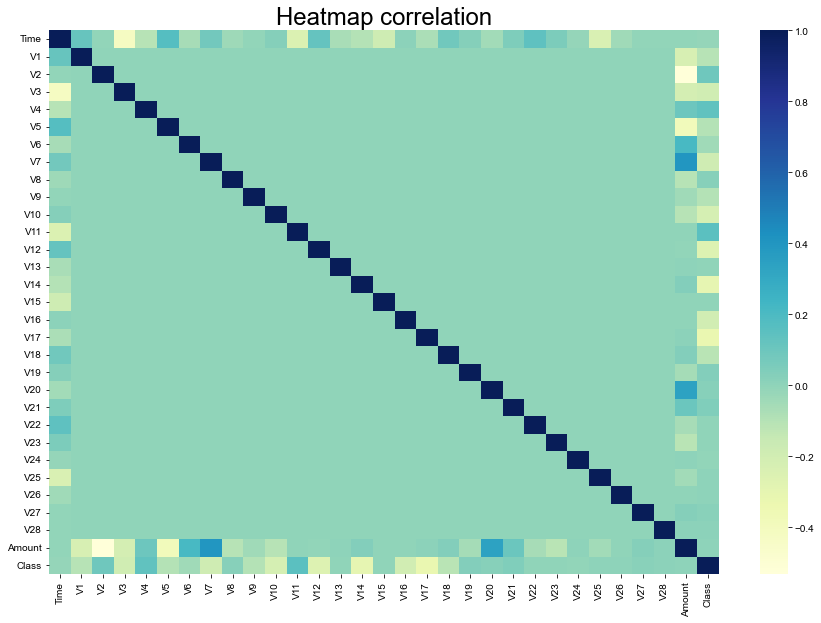

In [124]:
df_corr = df1.corr()

plt.figure(figsize=(15,10))
sns.heatmap(df_corr, cmap="YlGnBu") # Displaying the Heatmap
sns.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

As we can notice, most of the features are not correlated with each other. This corroborates the fact that a PCA was previously performed on the data.

What can generally be done on a massive dataset is a dimension reduction. By picking th emost important dimensions, there is a possiblity of explaining most of the problem, thus gaining a considerable amount of time while preventing the accuracy to drop too much.

However in this case given the fact that a PCA was previously performed, if the dimension reduction is effective then the PCA wasn't computed in the most effective way. Another way to put it is that no dimension reduction should be computed on a dataset on which a PCA was computed correctly.

In [125]:
rank = df_corr['Class']

In [131]:
df_train_all = df1[0:150000]
df_train_1 = df_train_all[df_train_all['Class'] == 1]
df_train_0 = df_train_all[df_train_all['Class'] == 0]


sz = len(df_train_1)

df_sample = df_train_0.sample(300)
df_train = df_train_1.append(df_sample)

df_train = df_train.sample(frac = 1)

In [132]:
print(df_train.shape)

(593, 31)


In [157]:
X_train = df_train.drop(['Time', 'Class'], axis = 1) #Time is useless and Class is Target variable
y_train = df_train['Class']
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [158]:
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [159]:
pred = classifier.predict(X_train)

In [160]:
accuracy_score(y_train, pred)

0.9612141652613828


Linear SVM Model accuracy score: 0.9612


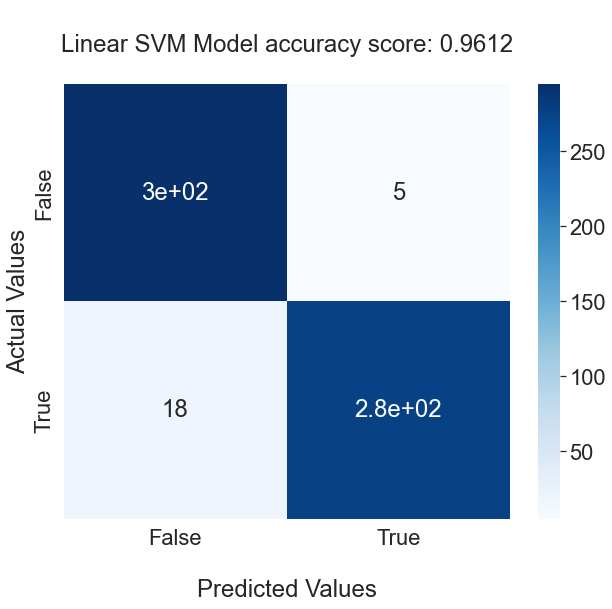

In [161]:
cf_matrix2 = confusion_matrix(y_train, pred)

ax = sns.heatmap(cf_matrix2, annot = True, cmap='Blues')

ax.set_title('\nLinear SVM Model accuracy score: {0:0.4f}\n'. format(accuracy_score(y_train, pred)));
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

print('\nLinear SVM Model accuracy score: {0:0.4f}'. format(accuracy_score(y_train, pred)))
## Ticket labels - List must be in alphabetical order

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

##Displat the visualization of the confusion Matrix
plt.show()

In [162]:
D = np.diagflat(y_train)
m = X_train.shape[0]
n = X_train.shape[1]

for i in range(m):
    if D[i][i] == 0:
        D[i][i] = -1

In [163]:
I = np.identity(m)
nu = 1

# define H matrix
o = np.ones((m, 1))
H = D.dot(np.concatenate([X_train, -o], axis = 1))

#calculate u
u = np.linalg.inv(I+H.dot(H.T)).dot(o)

In [164]:
w = X_train.T.dot(D).dot(u)
gamma = (-o.T).dot(D).dot(u)
error = u/nu

In [165]:
pred = (X_train.dot(w)-gamma) > 0


Linear PSVM Model accuracy score: 0.9157


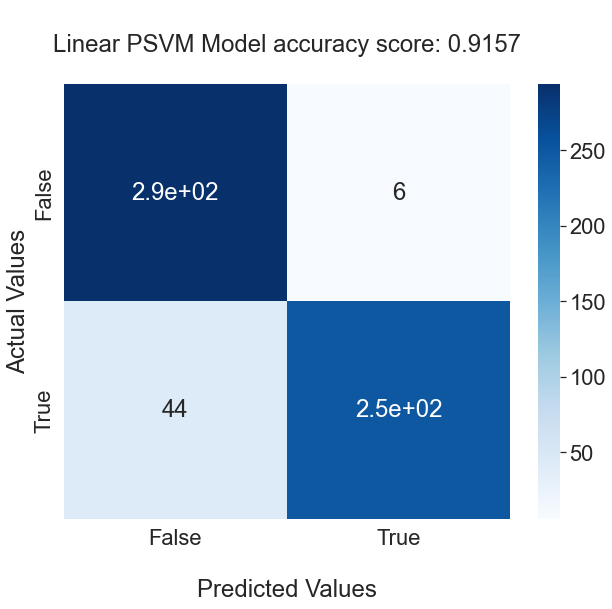

In [167]:
cf_matrix2 = confusion_matrix(y_train, pred)

ax = sns.heatmap(cf_matrix2, annot = True, cmap='Blues')

ax.set_title('\nLinear PSVM Model accuracy score: {0:0.4f}\n'. format(accuracy_score(y_train, pred)));
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

print('\nLinear PSVM Model accuracy score: {0:0.4f}'. format(accuracy_score(y_train, pred)))
## Ticket labels - List must be in alphabetical order

ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

##Displat the visualization of the confusion Matrix
plt.show()